### Equipo 2

**Cruz Hernández Julio César**

**Flores Noriega Ana Laura**

**Rodríguez Fitta Emanuel**

**Ramos Corona Leonardo Alfonso**


#### Tarea 4


**Objetivo:** El participante identificará el conjunto de características textuales que permiten mejorar los modelos de aprendizaje supervisado para la clasificación de textos, a partir de los métodos existentes para ello y con la ayuda de las bibliotecas implementadas en Python.

**Instrucciones:**

El participante debe con esta actividad integrar todos los conocimientos adquiridos hasta el momento, y puede incorporar los próximos conocimientos que adquirirá durante el módulo. Debe de aplicar tareas para el preprocesamiento de textos, hacer uso de expresiones regulares, incorporar características al clasificador, aplicar los algoritmos de clasificación supervisado binaria, realizar y anotar las diferentes pruebas realizadas así como los valores de F1 como métrica de evaluación.


**Situación a resolver:**


El discurso de odio se define comúnmente como cualquier comunicación que menosprecia a una persona o un grupo en función de algunas características. En el año 2019 se celebró la competencia: SemEval-2019 International Workshop on Semantic Evaluation ( https://alt.qcri.org/semeval2019/ ) planteándose 12 tareas. De la Task 5: “Multilingual detection of hate speech against immigrants and women in Twitter (hatEval)” se planteó lo referente al discurso de odio en redes sociales, en específico la red social Twitter (https://competitions.codalab.org/competitions/19935 ).

TAREA A - Detección de discursos de odio contra inmigrantes y mujeres: una clasificación de dos clases (binaria) donde los sistemas deben predecir si un tuit en inglés o en español con un objetivo determinado (mujeres o inmigrantes) es odioso o no odioso.

Trabajar con la tarea A, dejando a libre escoger uno de los 2 idiomas.
Realice diferentes pruebas (mínimo 3). Anote los resultados obtenidos por cada una de ellas, y asuma diferentes características en el entrenamiento del clasificador binario.
Sugerencias:

Para el preprocesamiento de los textos puede:

* Estandarizar el texto a minúsculas

* Eliminar las menciones a usuarios (@user)

* Eliminar las url’s

* Eliminar los emojis

* Las abreviaturas, contracciones y slangs sustituirlas por el texto equivalente

* Eliminar palabras funcionales

* Verificar si existen cifras numéricas, las cuales pueden ser reemplazadas por algún término o eliminarlas

* Tratamiento con los hashtags

* Eliminar caracteres raros y especiales

* Eliminar signos de puntuación

* Estandarizar las secuencias de varios espacios en blanco, tabuladores y saltos de línea

* Entre otras…

Posibles características para tenerse en cuenta:

* N-gramas de caracteres

* N-gramas de palabras

* N-gramas de etiquetas POS

* N-gramas de saltos de palabras (skip-gram)

* N-gramas de palabras funcionales

* N-gramas de símbolos de puntuación

* Entre otras…

### En una primera parte se realiza la detección de características textuales mediante código implementado en el módulo de Aprendizaje máquina supervisado.
> Se anexaron funcionalidades a la función vista en clase para realizar la limpieza del corpus.

> Se utiliza GridSearch-CrossValidation (GridSearchCV) que se aplica sobre un arreglo de algoritmos e hiperparámetros, iterando hasta encontar el mejor algoritmo y los mejores parámetros con el mejor Accuracy.

> Los algoritmos que se iteraron fueron: LogisticRegression(), MultinomialNB() y KNeighborsClassifier()

### En una segunda parte se replicó el código realizado en clase aplicándolo a los textos de discursos de odio.

## Primera parte

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from textblob.np_extractors import ConllExtractor
from textblob import TextBlob
import en_core_web_sm
import spacy
from spacy.lang.es.examples import sentences

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, plot_roc_curve, roc_auc_score

import requests
import joblib

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('conll2000')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

# Con los Training Data

In [ ]:
# Contracciones
df_con = pd.read_csv('SPcontractions.txt', sep = '\t', names = ['con', 'sig'])
# Abreviaciones
df_abb = pd.read_csv('SPabb.txt', sep = '\t', names = ['abb', 'sig'])
# Slang
df_slang = pd.read_csv('SPslang.txt', sep = '\t', names = ['slang', 'sig'], index_col = False)
# Tweets
data = pd.read_csv('train_es.tsv', sep = '\t')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,id,text,HS,TR,AG
0,20001,Easyjet quiere duplicar el número de mujeres p...,1,0,0
1,20002,El gobierno debe crear un control estricto de ...,1,0,0
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0,0,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0,0,0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0,0,0


In [ ]:
def nube_palabras(texto):
  wordcloud = WordCloud(width = 800, height = 500, 
                      random_state = 21, 
                      max_font_size = 100, 
                      relative_scaling = 0.5, 
                      colormap='Dark2').generate(texto)
  plt.figure(figsize=(14, 10))
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.axis('off')
  plt.show()

In [ ]:
def data_process(data, dev_mode = True):
  
  tweets = data[['text', 'HS']].copy()

  # Estandarización a minúsculas
  tweets['modified_text'] = tweets['text'].str.lower()

  # Eliminar mención a usuarios
  tweets['modified_text'] = tweets['modified_text'].str.replace('@([A-Za-z0-9_]+)', ' ', regex = True) 

  # Eliminar urls
  pattern_URL="(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})"
  tweets['modified_text'] = tweets['modified_text'].str.replace(pattern_URL, ' ', regex = True) 

  # ELiminar emojis
  emoji_pattern = re.compile("["
                                 "\U0001F600-\U0001F64F"  # emoticons
                                 "\U0001F300-\U0001F5FF"  # symbols & pictographs                               
                                 "\U0001F680-\U0001F6FF"  # transport & map symbols
                                 "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                 "\U00002702-\U000027B0"
                                 "\U000024C2-\U0001F251"
                                 "\U0001f926-\U0001f937"
                                 "\u200d"
                                 "\u2640-\u2642"
                                 "\U0001F1F2-\U0001F1F4"  # Macau flag
                                 "\U0001F1E6-\U0001F1FF"  # flags
                                 "\U0001F600-\U0001F64F"
                                 "\U0001F1F2"
                                 "\U0001F1F4"
                                 "\U0001F620"
                                 "]+", flags=re.UNICODE)   
  tweets['modified_text'] = tweets['modified_text'].str.replace(emoji_pattern, ' ', regex = True) 

  #Acentos
  trans = str.maketrans('áéíóúü', 'aeiouu')
  tweets['modified_text'] = tweets['modified_text'].str.translate(trans)

  # Eliminación de signos y caracteres raros
  tweets['modified_text'] = tweets['modified_text'].str.replace(r"[^a-zA-Zñ# ]", "", regex = True)

  # Transformacion de abreviaciones
  for i in range(len(df_abb)):
    tweets['modified_text'] = tweets['modified_text'].str.replace("\b%s\b" % df_abb.iloc[i, 0], df_abb.iloc[i, 1].lower(), regex = True)    

  # Transformacion de contracciones
  for i in range(len(df_con)):
    tweets['modified_text'] = tweets['modified_text'].str.replace("\b%s\b" % df_con.iloc[i, 0], df_con.iloc[i, 1].lower(), regex = True)

  # Transformacion de slang
  for i in range(len(df_slang)):
    tweets['modified_text'] = tweets['modified_text'].str.replace("\b%s\b" % df_slang.iloc[i, 0], df_slang.iloc[i, 1].lower(), regex = True) 

  # Eliminación de palabras funcionales
  palabras_funcionales = set(nltk.corpus.stopwords.words('spanish'))
  for stopword in palabras_funcionales:
    tweets['modified_text'] = tweets['modified_text'].str.replace(r"\b%s\b" % stopword, ' ', regex = True)


  # Hashtags más usados
  h = tweets['modified_text'].apply(lambda tweet: re.findall(r"#(\w+)", tweet))
  ht = []
  for i in h:
    if len(i) != 0:
      for j in range(len(i)):
        ht.append(i[j])

  a = nltk.FreqDist(ht)
  d = pd.DataFrame({'Hashtag': list(a.keys()),
                        'Count': list(a.values())})
  d = d.nlargest(columns = 'Count', n = 20)

  if dev_mode:
    plt.figure(figsize = (10, 5))
    sns.barplot(data = d, x = 'Hashtag', y = 'Count')
    plt.title('Hashtags más usados')
    plt.xticks(rotation = 90);


  # Eliminación de hashtags
  tweets['modified_text'] = tweets['modified_text'].str.replace(r'#(\w+)', ' ', regex = True)
  #tweets['modified_text'] = tweets['modified_text'].str.replace(r'(#)[a-z]+', '', regex = True)

  # Eliminación de jajaja
  tweets['modified_text'] = tweets['modified_text'].str.replace(r'a*(ja+)j*', ' ', regex = True)

  # Eliminación de palabras de menos de tres letras
  tweets['modified_text'] = tweets['modified_text'].str.replace(r"\b(\w{1,3})\b", ' ', regex = True)

  # Correción de palabras con letras repetidas
  tweets['modified_text'] = tweets['modified_text'].apply(lambda tweet: re.sub(r"(\w)\1{2,}", r"\1", tweet))

  # Eliminación de espacios en blanco al inicio y al final
  tweets['modified_text'] = tweets['modified_text'].str.strip()

  # Varios espacios en blanco
  tweets['modified_text'] = tweets['modified_text'].str.replace(r'\s{2,}', ' ', regex = True) 

  # FRases relevantes
  textblob_key_phrases = []
  extractor = ConllExtractor()
  for words in tweets['modified_text']:
      blob = TextBlob(words, np_extractor=extractor)
      textblob_key_phrases.append(list(blob.noun_phrases))

  tweets['phrases'] = textblob_key_phrases
  tweets['phrases'] = tweets['phrases'].apply(lambda lista: ' '.join(lista))

  # Lemmatizando
  spanish_stemmer = SnowballStemmer('spanish')
  tweets['words'] = tweets['phrases'].str.split(' ')
  tweets['words'] = tweets['words'].apply(lambda lista: ' '.join( list(map(spanish_stemmer.stem, lista))) )

  # Etiquetado
  nlp = en_core_web_sm.load()
  pos_col = []
  dep_col = []
  for tweet in tweets['phrases']:
    pos = []
    dep = []
    doc = nlp(tweet)
    for token in doc:
      pos.append(token.pos_.lower())
      dep.append(token.dep_.lower())
    pos_col.append(pos)
    dep_col.append(dep)

  tweets['pos'] = pos_col
  tweets['pos'] = tweets['pos'].apply(lambda lista: list(set(lista)))
  tweets['pos'] = tweets['pos'].apply(lambda lista: ' '.join(lista))

  tweets['dep'] = dep_col
  tweets['dep'] = tweets['dep'].apply(lambda lista: list(set(lista)))
  tweets['dep'] = tweets['dep'].apply(lambda lista: ' '.join(lista))

  if dev_mode:
    # Nube de palabras
    positivo = ' '.join([text for text in tweets['phrases'][tweets['HS'] == 0]])
    print('Nube de palabras positivas')
    nube_palabras(positivo)

    negativo = ' '.join([text for text in tweets['phrases'][tweets['HS'] == 1]])
    print('Nube de palabras negativas')
    nube_palabras(negativo)

    # Guardamos tweets procesados
    try:
      tweets.to_csv('tweets_processed.csv', index = False)
      print('Archivo guardado')
    except:
      print('Ocurrió un Error')

  return tweets

In [ ]:
# Cargamos archivo, en caso de ser necesario
# try:
#   tweets = pd.read_csv('tweets_processed.csv')
#   print('Archivo cargado')
# except:
#   print('Archivo no encontrado')

Nube de palabras positivas


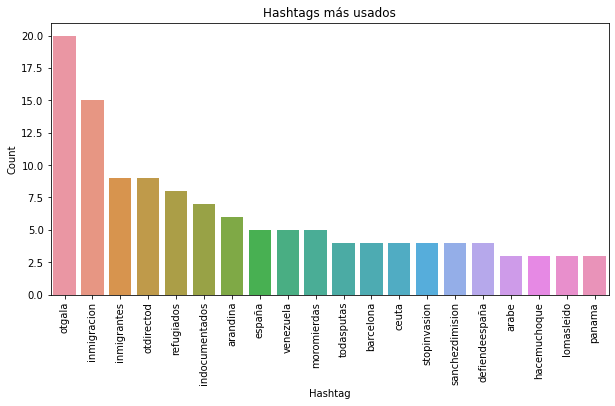

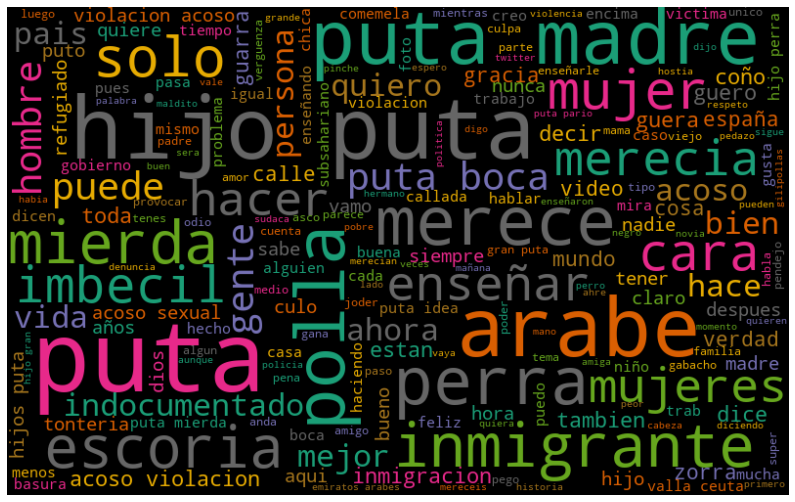

Nube de palabras negativas


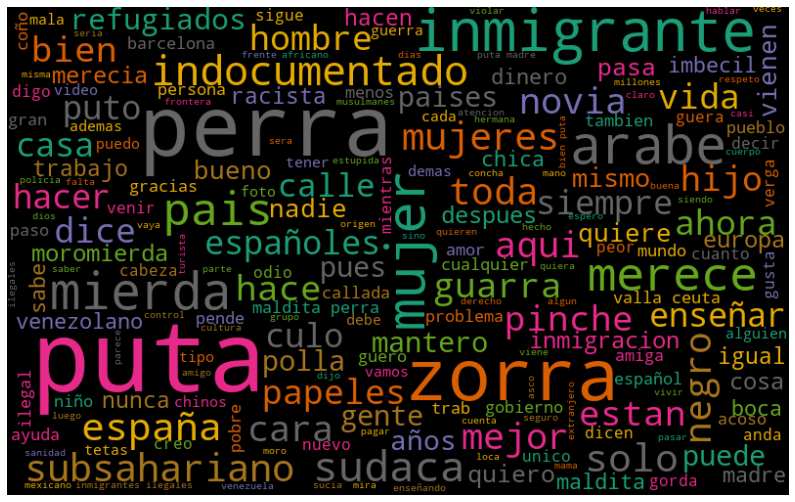

Archivo guardado
CPU times: user 58.8 s, sys: 648 ms, total: 59.5 s
Wall time: 59.4 s


In [ ]:
%%time
tweets = data_process(data = data, dev_mode = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets[['words', 'pos', 'dep']], tweets['HS'], test_size = 0.2, random_state = 42, stratify = tweets['HS'])

In [ ]:
tvectorizer_w = TfidfVectorizer(
    # lowercase=True,
    #stop_words=[word.decode('utf-8') for word in nltk.corpus.stopwords.words('spanish')],
    token_pattern=r'\b\w+\b', #selects tokens of 2 or more alphanumeric characters 
    ngram_range = (1,3),#n-grams de palabras n = 1 a n = 3 (unigramas, bigramas y trigramas)
    min_df = 5,#ignorando los términos que tienen una frecuencia de documento estrictamente inferior a 5
).fit(X_train['words'])
X_train_vec_w = tvectorizer_w.transform(X_train['words']).toarray()
X_test_vec_w = tvectorizer_w.transform(X_test['words']).toarray()

In [ ]:
tvectorizer_p = TfidfVectorizer(
    # lowercase=True,
    #stop_words=[word.decode('utf-8') for word in nltk.corpus.stopwords.words('spanish')],
    token_pattern=r'\b\w+\b', #selects tokens of 2 or more alphanumeric characters 
    ngram_range = (1,3),#n-grams de palabras n = 1 a n = 3 (unigramas, bigramas y trigramas)
    min_df = 5,#ignorando los términos que tienen una frecuencia de documento estrictamente inferior a 5
).fit(X_train['pos'])
X_train_vec_p = tvectorizer_p.transform(X_train['pos']).toarray()
X_test_vec_p = tvectorizer_p.transform(X_test['pos']).toarray()

In [ ]:
tvectorizer_d = TfidfVectorizer(
    # lowercase=True,
    #stop_words=[word.decode('utf-8') for word in nltk.corpus.stopwords.words('spanish')],
    token_pattern=r'\b\w+\b', #selects tokens of 2 or more alphanumeric characters 
    ngram_range = (1,3),#n-grams de palabras n = 1 a n = 3 (unigramas, bigramas y trigramas)
    min_df = 5,#ignorando los términos que tienen una frecuencia de documento estrictamente inferior a 5
).fit(X_train['dep'])
X_train_vec_d = tvectorizer_d.transform(X_train['dep']).toarray()
X_test_vec_d = tvectorizer_d.transform(X_test['dep']).toarray()

In [ ]:
train_features = pd.concat([pd.DataFrame(X_train_vec_w), pd.DataFrame(X_train_vec_p), pd.DataFrame(X_train_vec_d)], axis = 1)
test_features = pd.concat([pd.DataFrame(X_test_vec_w), pd.DataFrame(X_test_vec_p), pd.DataFrame(X_test_vec_d)], axis = 1)

In [ ]:
smote = SMOTE(random_state = 42)
train_smote, y_train_smote  = smote.fit_resample(train_features.values, y_train)

#### Utilizamos Grid Search y Cross Validation sobre un iterador para encontrar el mejor algoritmo y los mejores hiperparámetros

In [ ]:
parameters = [
              {"C": [1, 0.1, 0.001, 0.0001, 0.00001]},
              # {'n_estimators': [100, 300, 500, 800], 'oob_score': [True]},
              # {'C': [1, 10, 100],'gamma': [1, 0.1, 0.001]},
              {'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} ,
              {'n_neighbors': [3, 6, 9, 12], 'leaf_size': [10, 20, 30]}
]

models = [
          LogisticRegression(),
          MultinomialNB(),
          # RandomForestClassifier(),
          # SVC(),
          KNeighborsClassifier()
]

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1001)

In [ ]:
%%time
scores = []
best_models = []
print('> Iniciando iteraciones...')

for i in range(len(models)):
  pipe = make_pipeline(
      MinMaxScaler(),
      GridSearchCV(
          estimator = models[i],
          param_grid = parameters[i],
          cv = cv,
          scoring = 'f1',
          n_jobs = -1,
          verbose = 5
      )
  )

  print('>> Encontrando parametros...')
  print(f'>> Modelo {models[i]}...')

  pipe.fit(train_smote, y_train_smote)
  yhat = pipe.predict(test_features)
  scores.append(f1_score(y_test, yhat))
  best_models.append(pipe.steps[1][1].best_estimator_)

  print(f'>>> Best parameters {pipe.steps[1][1].best_params_}')
  print(f'>>> Best training score {pipe.steps[1][1].best_score_}')
    

best_score = max(scores)
index_best_score = scores.index(best_score)
best_model = best_models[index_best_score]
print('> Guardando mejor modelo')
joblib.dump(best_model, 'best_model')

print('> Summary ...\n')
print(f'Best model {best_model}')
print(f'Best f1 score {best_score}')

> Iniciando iteraciones...
>> Encontrando parametros...
>> Modelo LogisticRegression()...
Fitting 10 folds for each of 5 candidates, totalling 50 fits
>>> Best parameters {'C': 1}
>>> Best training score 0.8002591736711804
>> Encontrando parametros...
>> Modelo MultinomialNB()...
Fitting 10 folds for each of 6 candidates, totalling 60 fits
>>> Best parameters {'alpha': 1}
>>> Best training score 0.7539434138784582
>> Encontrando parametros...
>> Modelo KNeighborsClassifier()...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
>>> Best parameters {'leaf_size': 10, 'n_neighbors': 3}
>>> Best training score 0.6790501767484299
> Guardando mejor modelo
> Summary ...

Best model LogisticRegression(C=1)
Best f1 score 0.7246753246753247
CPU times: user 5.54 s, sys: 836 ms, total: 6.38 s
Wall time: 53.2 s


## El mejor modelo resulta ser el de Regresión Logística con C=1,con un score de entrenamiento de 80%. El score F1 es de 72%

# Probamos con el dataset de Test Data

In [ ]:
# Procesamos los tweets
data = pd.read_csv('dev_es.tsv', sep = '\t')
tweets = data_process(data = data, dev_mode = False)

In [ ]:
tweets

,text,HS,modified_text,phrases,words,pos,dep
0,Me estoy comiendo la picada árabe más rica de ...,0,comiendo picada arabe rica vida,comiendo picada arabe rica vida,com pic arab ric vid,propn,amod root compound
1,@Haryachyzaychyk Callate zorra y mama duro! 😍,1,callate zorra mama duro,zorra mama duro,zorr mam dur,propn,root compound
2,Acabo de escuchar a Casado diciendo que hay DE...,0,acabo escuchar casado diciendo decenas millone...,acabo escuchar casado diciendo decenas millone...,acab escuch cas dic decen millon subsaharian a...,propn,nsubj root compound
3,Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR...,1,nadie preguntado costar hombre guantazo situac...,nadie preguntado costar hombre guantazo situac...,nadi pregunt cost hombr guantaz situacion segu...,propn,compound nsubj npadvmod root
4,"@Fed_Durand Callate come sobra, más zorra son ...",1,callate come sobra zorra,sobra zorra,sobr zorr,propn,root compound
...,...,...,...,...,...,...,...
495,@Rafhyta86 @ElDesmadre__ Habe pasame el video ...,1,habe pasame video adan diga puta mujeres sevil...,habe pasame video adan diga puta mujeres sevil...,hab pasam vide adan dig put mujer sevillistasm...,propn noun,nsubj root advmod compound
496,"@IgnacioSena1 Callate hijo de perra , como est...",0,callate hijo perra amor,hijo perra amor,hij perr amor,propn,root compound
497,@PabloFonta86 @TowandaRebels pero tu eres un a...,0,autentico imbecil potencial machista ideologia...,autentico imbecil potencial machista ideologia...,autent imbecil potencial machist ideologi izqu...,propn adj,compound dobj root
498,"@celesteborghi5 callate q le paso a mili, m pa...",1,callate paso mili paso faltas gorda puta posible,paso mili paso faltas gorda puta posible,pas mili pas falt gord put posibl,propn adj verb noun,amod root advmod compound


In [ ]:
X = tweets[['words', 'pos', 'dep']]
y = tweets['HS']

X_vec_w = tvectorizer_w.transform(X['words']).toarray()
X_vec_p = tvectorizer_p.transform(X['pos']).toarray()
X_vec_d = tvectorizer_d.transform(X['dep']).toarray()

features = pd.concat([pd.DataFrame(X_vec_w), pd.DataFrame(X_vec_p), pd.DataFrame(X_vec_d)], axis = 1)

In [ ]:
yhat = best_model.predict(features)

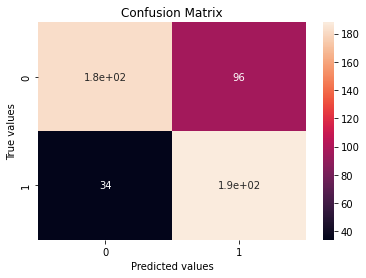

In [ ]:
sns.heatmap(confusion_matrix(y, yhat), annot = True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('True values');

ACU Score 0.7507615529198263


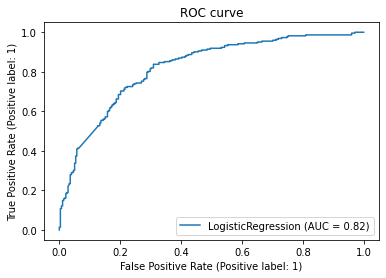

In [ ]:
plot_roc_curve(estimator = best_model, X = features, y = y)
plt.title('ROC curve');
print(f'ACU Score {roc_auc_score(y, yhat)}')

In [ ]:
print(f'> Accuracy {accuracy_score(y, yhat)}')
print(f'> Recall Score {recall_score(y, yhat)}')
print(f'> Precision Score {precision_score(y, yhat)}')
print(f'> f1 Score {f1_score(y, yhat)}')

> Accuracy 0.74
> Recall Score 0.8468468468468469
> Precision Score 0.6619718309859155
> f1 Score 0.7430830039525691


Receiver operating characteristics (ROC): considera todos los thresholds posibles para un clasificacdor dado, pero a diferencia de reportar el precision y recall, nos muestra la tasa de falsos positivos (FPR) contra la tasa de verdaderos positivos (TPR).

La curva ideal está cerca de la esquina superior izquierda: queremos un clasificador que nos de un recall alto manteniendo una tasa de falsos positivos baja. Para este caso es Accuracy para el mejor modelo (LogisticRegression) es de 74.3%.

**Interpretación: Se generaron varias métricas de evaluación del modelo utilizando el mejor algoritmo (LogisticRegression con c=1) almacenado en la variable best_model. La mejor métrica resulta ser por mucho el Recall Score: Muestras positivas que fueron capturadas por predicciones positivas, lo que sugiere que debemos reducir o evitar los Falsos Negativos.**

**De la matriz de confusión y previamente comentado encontramos que sería conveniente tratar de reducir los Falsos Negativos, esto es, si tenemos un alto número de Falsos Negativos entonces los tweets no clasificados como violentos en realidad si lo son. Esto puede traer consecuencias no deseadas debido a que los usuarios podrían continuar promoviendo el discurso de odio dado que no serían detectados como tal.**

## Segunda parte. Replicando el código visto en clase

In [10]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('conll2000')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In [11]:
corpus_train_esA = pd.read_csv('train_es.tsv',delimiter='\t',encoding='utf-8')
corpus_dev_esA = pd.read_csv('dev_es.tsv',delimiter='\t',encoding='utf-8')

#### Agregamos algunas otras características en el preprocesamiento como eliminación de las palabras 'ja', eliminación de hastags y espacios en blanco adicionales

In [12]:
pattern_URL="(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})"

def procesar(file, namefile):    
    file[file.columns[1]] = [clean_text(i) for i in file[file.columns[1]]]    
    file.to_csv(namefile, sep='\t', encoding='utf-8', index=False)
    return file
    
def clean_text(text):
    text = text.lower()   
    text=re.sub("@([A-Za-z0-9_]{1,15})", " ", text)
    text=re.sub(pattern_URL, " ", text)
    
    text=re.sub("((ja){2,30})", " ", text) # elimina jaja+
    text= re.sub("(#(\w+))", " ", text) # eliminar hashtags
    text = re.sub("s +", "", text) # eliminar espacios en blanco adicionales
       
    text= remove_emoji(text)
    text= remove_stopwords(text)
    text=re.sub("\d+", " ", text)
    
    text=re.sub(r" +", " ", re.sub(r"\t", " ", re.sub(r"\n+", "\n", re.sub('(?:[.,\/!$%?¿?!¡\^&\*;:{}=><\-_`~()”“"\'\|])', " ",text))))
    text = text.strip()
    return text

def remove_stopwords(text):    
    stopwords=set(nltk.corpus.stopwords.words("spanish"))
    for i in stopwords:
        text = re.sub(r"\b%s\b" % i, " ", text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               "\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs                               
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "\U00002702-\U000027B0"
                               "\U000024C2-\U0001F251"
                               "\U0001f926-\U0001f937"
                               "\u200d"
                               "\u2640-\u2642"
                               "\U0001F1F2-\U0001F1F4"  # Macau flag
                               "\U0001F1E6-\U0001F1FF"  # flags
                               "\U0001F600-\U0001F64F"
                               "\U0001F1F2"
                               "\U0001F1F4"
                               "\U0001F620"
                               "]+", flags=re.UNICODE)   
    text = emoji_pattern.sub(r'', text) # no emoji
    return text

In [13]:
# Gurdamos el corpus procesado
corpus_train_esA = procesar(corpus_train_esA, "train_es_cleanA.tsv")
corpus_dev_esA = procesar(corpus_dev_esA, "dev_es_cleanA.tsv")

In [14]:
corpus_train_esA

,id,text,HS,TR,AG
0,20001,easyjet quiere duplicar número mujerepiloto ve...,1,0,0
1,20002,gobierno debe crear control estricto inmigraci...,1,0,0
2,20003,veo mujeredestruidapor acoso laboral callejero...,0,0,0
3,20004,— respetuoso lodemás sólamente lerecuerdo si e...,0,0,0
4,20007,antonio caballero ser mal gusto ignorante vez ...,0,0,0
...,...,...,...,...,...
4464,24996,cállateeee zorra ahre,1,1,1
4465,24997,presidente cúcuta tenemoproblemacon venezolano...,1,0,1
4466,24998,callaté visto dejo puta,0,0,0
4467,24999,lohombrese casan lamujeres lacabrano saben fre...,1,0,0


#### Leyendo el corpus ya procesado-limpio

In [15]:
# Identificador del trining
# train_idA = corpus_train_esA[corpus_train_esA.columns[0]]

# Características independientes del train
X_train = corpus_train_esA[corpus_train_esA.columns[1]].fillna(' ')

# Variable a predecir: clasificador binario del train
y_train = corpus_train_esA[corpus_train_esA.columns[2]]

# Identificador del test
# test_idA = corpus_dev_esA[corpus_train_esA.columns[0]]

# Características independientes del test
X_test = corpus_dev_esA[corpus_dev_esA.columns[1]].fillna(' ')

# Variable a predecir: clasificador binario del test
y_test = corpus_dev_esA[corpus_dev_esA.columns[2]]

In [16]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4469 4469
500 500


#### Verificamos el balance de los valores de ceros y unos tanto en el train como en el test, verificando que en ambos existan valores similares de ceros y unos.

(array([2631.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1838.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

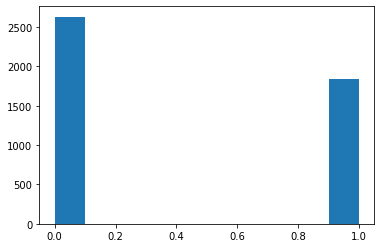

In [17]:
import matplotlib.pyplot as plt
# Datos de entrenamiento
plt.hist(y_train)

(array([278.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 222.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

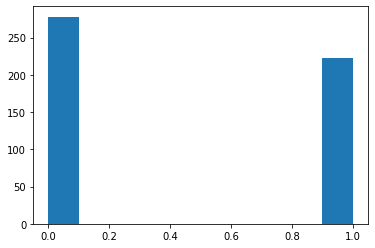

In [18]:
# Datos de prueba
plt.hist(y_test)

#### Los valores de ceros y unos están relativamente bien balanceados y existe una consistencia entre los valores en training y test.

Ajustar y transformar los datos de entrenamiento `X_train` utilizando un `count_vectorizer` con parámetros predeterminados.

Luego, ajuste un modelo de clasificación Naive Bayes multinomial con suavizado (smoothing) `alpha = 0.1`. Encuentre el área bajo la curva (AUC) usando los datos de prueba transformados.

*Esta función debe devolver además: accuracy, AUC y F1 como un flotante.*

In [19]:
# Generamos la matriz de término de documentos con solo conteo de palabras
cvectorizer = CountVectorizer(
    ngram_range=(1,3), # n-gramas de palabras n = 1 a n = 3 (unigramas, bigramas y trigramas)
    min_df = 5, # Ignorando los términos que tienen una frecuencia de documento estrictamente inferior a 5
).fit(X_train)

X_train_cvectorized = cvectorizer.transform(X_train).toarray()
print(X_train_cvectorized.shape)

X_test_cvectorized = cvectorizer.transform(X_test).toarray()
print(X_test_cvectorized.shape)

(4469, 1477)
(500, 1477)


In [20]:
# Generamos la matriz de término de documentos como producto de la frecuencia de los
# términos y la frecuencia inversa de los documentos.
# Esta estadística numérica que pretende reflejar la importancia de una palabra para un documento en una colección o corpus.

tvectorizer = TfidfVectorizer(
    ngram_range=(1,3), #n-gramas de palabras n = 1 a n = 3 (unigramas, bigramas y trigramas)
    min_df=5, # Ignorando los términos que tienen una frecuencia de documento estrictamente inferior a 5
).fit(X_train)

X_train_tvectorized = tvectorizer.transform(X_train).toarray()
print(X_train_tvectorized.shape)

X_test_tvectorized = tvectorizer.transform(X_test).toarray()
print(X_test_tvectorized.shape)

(4469, 1477)
(500, 1477)


In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score #son metricas - area debajo de la curva roc

def respuesta_dos():
    vect = CountVectorizer().fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    
    clf1 = MultinomialNB()
    clf2 = MultinomialNB(alpha=0.1) # Con suavizado
    
    clf1.fit(X_train_vectorized, y_train) # ajusta al calificador 1
    clf2.fit(X_train_vectorized, y_train) # ajusta al calificador 2
    
    X_test_vectorized = vect.transform(X_test)
    
    predictions1 = clf1.predict(X_test_vectorized) # funcion para predecir 1
    predictions2 = clf2.predict(X_test_vectorized) # funcion para predecir 2
    
    print('Predicciones y resultados del clasificador 1')
    print('Predicciones', predictions1)
    # métricas para verificar que tanto es el calificador es correcto
    print( 'Accuracy', accuracy_score(y_test, predictions1) )
    print( 'AUC', roc_auc_score(y_test, predictions1) )
    print( 'F1', f1_score(y_test, predictions1) )
    
    print('\n')
    
    print('Predicciones y resultados del clasificador 2')
    print('Predicciones', predictions2)
    # métricas para verificar que tanto es el calificador es correcto
    print('Accuracy', accuracy_score(y_test, predictions2) )
    print('AUC', roc_auc_score(y_test, predictions2))
    print('F1', f1_score(y_test, predictions2))

In [24]:
respuesta_dos()

Predicciones y resultados del clasificador 1
Predicciones [0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0
 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0
 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0
 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0

Ajustar y transformar los datos de entrenamiento `X_train` utilizando un `TfidfVectorizer` ignorando los términos que tienen una frecuencia de documento estrictamente inferior a **3**.

Luego, ajuste un modelo de clasificador Naive Bayes multinomial con suavizado (smoothing) `alfa = 0.1` y calcule el área bajo de la curva (AUC) usando los datos de prueba transformados.

*Esta función debe devolver el F1 como un flotante.*

In [25]:
# Caculando el clasificador considerando la importancia de las palabras.
def respuesta_tres():
    vect = TfidfVectorizer(min_df=3).fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    
    clf1=MultinomialNB()
    clf2=MultinomialNB(alpha=0.1)
    
    clf1.fit(X_train_vectorized, y_train) # Ajusta al calificador 1
    clf2.fit(X_train_vectorized, y_train) # Ajusta al calificador 2
    
    X_test_vectorized = vect.transform(X_test)
    
    predictions1 = clf1.predict(X_test_vectorized)
    predictions2 = clf2.predict(X_test_vectorized)
    
    print('Clasificador 1 - Métrica F1', f1_score(y_test, predictions1))
    print('Clasificador 2 - Métrica F1', f1_score(y_test, predictions2))

In [26]:
respuesta_tres()

Clasificador 1 - Métrica F1 0.6510416666666666
Clasificador 2 - Métrica F1 0.6281407035175879


Combinando nuevas características en los datos de entrenamiento

In [27]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

Ajustar y transformar los datos de entrenamiento `X_train` usando un `TfidfVectorizer` ignorando los términos que tienen una frecuencia de documento estrictamente inferior a **5**.

Usando esta matriz de término de documento y una característica adicional, **la longitud del documento (número de caracteres)**, ajustar a un modelo de Clasificación de Vector de Soporte con regularización `C = 10000`.

*Esta función debe devolver el F1 como un flotante.*

In [28]:
from sklearn.svm import SVC, LinearSVC

def respuesta_cinco():
    vect = TfidfVectorizer(min_df=5).fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    
    num_chars = X_train.str.len()
    
    print(X_train_vectorized.shape)
    X_train_vectorized = add_feature(X_train_vectorized, num_chars)
    print(X_train_vectorized.shape)
    
    model = SVC(C=10000, random_state=0)
    modelLin = LinearSVC(C=10000, random_state=0)
    
    model.fit(X_train_vectorized, y_train)   
    modelLin.fit(X_train_vectorized, y_train)  
    
    X_test_vectorized = vect.transform(X_test)
    num_charsTest = X_test.str.len()
    X_test_vectorized = add_feature(X_test_vectorized, num_charsTest)
    
    predictions = model.predict(X_test_vectorized)
    predictionsLin = modelLin.predict(X_test_vectorized)
    
    return f1_score(y_test, predictions), f1_score(y_test, predictionsLin)

In [29]:
respuesta_cinco()

(4469, 1277)
(4469, 1278)


(0.6520681265206814, 0.637037037037037)

Ajustar y transformar los datos de entrenamiento `X_train` usando un `TfidfVectorizer` ignorando los términos que tienen una frecuencia de documento estrictamente inferior a **5** y usando **n-grams de palabras n = 1 a n = 3** (unigramas, bigramas y trigramas).

Usando esta matriz de término-documento y las siguientes características adicionales:
* la longitud del documento (número de caracteres)
* **cantidad de dígitos por documento**

Ajustar un modelo de Regresión logística con regularización `C = 100`.

*Esta función debe devolver el F1 como un flotante.*

In [30]:
from sklearn.linear_model import LogisticRegression

def respuesta_seis():    
    vect = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    num_chars = X_train.str.len()
    num_digits = X_train.str.count('\d')
    X_train_vectorized = add_feature(X_train_vectorized, num_chars)
    X_train_vectorized = add_feature(X_train_vectorized, num_digits)
    model = LogisticRegression(C=100)
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vect.transform(X_test)
    num_charsTest = X_test.str.len()
    num_digitsTest = X_test.str.count('\d')
    X_test_vectorized = add_feature(X_test_vectorized, num_charsTest)
    X_test_vectorized = add_feature(X_test_vectorized, num_digitsTest)    
    
    predictions = model.predict(X_test_vectorized)
    return f1_score(y_test, predictions)

In [31]:
respuesta_seis()

0.7050691244239631

### Interpretación

*Con los procesos realizados como el preprocesamiento de textos, el uso de expresiones regulares y la incorporación de características al clasificador aplicamos algunos algoritmos de clasificación de aprendizaje máquina supervisado para predecir una variable categórica que nos indica si un tweet es considerado como odioso o no lo es.*

**Accuracy**

El clasificador de Naive_bayes para un modelo Multinomial sin suavizar tuvo el mejor resultado: Hubo una predicción del 75% de Accuracy de que los tweets sean considerados como discursos de odio (odioso) contra migrantes y mujeres, es decir, aseguramos que el 75% de los documentos en el corpus son mensajes de odio o no lo son.

Support Vector Classifier (SVC) generó un Acuuracy del 65% y Linear Support Vector Classifier (Linear SVC) del 63%

El algoritmo de LogisticRegressión generó un Acuuracy de 70%.


**F1**

Los valores de F1 son:

70% en regresión logística

65% en SVC y 63% en Linear SVC

Entre 68 y 69% en Naive Bayes Multinomial

Los valores de F1 bajaron con relación al Accuracy, esto se debe debido a que al combinar las medidas de precisión (precision) y recall en un solo valor, reducimos los valores de Fasos Positivos y Falsos Negativos, entonces obtenemos valores de F1 discriminan los TP y TN. Esto es, comparamos el rendimiento combinado de la precisión y el recall entre varias soluciones.